# Low Frequency NCCF Exploration

- are the NCCFs giving reliable EGF below 5 Hz, where we have the most illumination
- I've seen a little a couple of things that make me think that they might be unreliable. Let's look into it a bit

In [181]:
import xarray as xr
import pandas as pd
import numpy as np
from dask.distributed import Client
from scipy import signal
import ODLintake
from xrsignal.xrsignal import xrsignal
from OOI_hydrophone_cloud import utils
from NI_tools.NI_tools import calculate, inversion
import matplotlib.pyplot as plt
import hvplot.xarray
from tqdm import tqdm
import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43283,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:43627,Total threads: 4
Dashboard: http://127.0.0.1:40919/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:36593,


In [3]:
NCCFs201 = xr.open_dataarray('/datadrive/NCCFs/averaged/201.nc')
NCCFs201 = NCCFs201.chunk({'time':100, 'delay':11999})

In [ ]:
lf_data = ODLintake.open_ooi_lfhydrophones()

## Check differences between filtering 1-90 NCCF and calculating NCCF between 1-5
- differences seem nominal for two NCCFs that I checked (2017-01-01, 2017-07-01)

In [37]:
start_time = pd.Timestamp('2017-03-01')
end_time = start_time + pd.Timedelta(hours=201)

hdata_slice = utils.slice_ds(lf_data, start_time, end_time, include_coord=False)[['AXCC1','AXEC2']]

In [38]:
NCCF_1_5 = calculate.compute_NCCF_stack(hdata_slice, dim='time', fcs=[1, 5]).mean('time')
NCCF_1_90 = calculate.compute_NCCF_stack(hdata_slice, dim='time', fcs=[1, 90]).mean('time')

In [39]:
b,a = signal.butter(4, [0.01, 0.05], btype='bandpass')
NCCF_1_90_lf = xrsignal.filtfilt(NCCF_1_90, b=b,a=a, dim='delay')

(-10.0, 10.0)

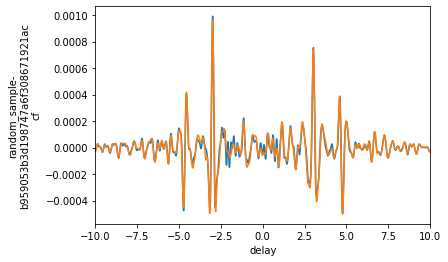

In [40]:
NCCF_1_90_lf.plot()
NCCF_1_5.plot()
plt.xlim([-10,10])

## Compare LF to BB at estimates

In [4]:
b,a = signal.butter(4, [0.01, 0.05], btype='bandpass')
NCCFs_1_5 = xrsignal.hilbert_mag(xrsignal.filtfilt(NCCFs201, b=b, a=a, dim='delay'), dim='delay').compute()

b,a = signal.butter(4, [0.1, 0.45], btype='bandpass')
NCCFs_10_45 = xrsignal.hilbert_mag(xrsignal.filtfilt(NCCFs201, b=b, a=a, dim='delay'), dim='delay').compute()

In [7]:
_ = NCCFs201.load()

In [8]:
arrival_times_1_5 = inversion.calculate_arrival_times(NCCFs_1_5, dim='delay')
arrival_times_1_90 = inversion.calculate_arrival_times(NCCFs201, dim='delay')

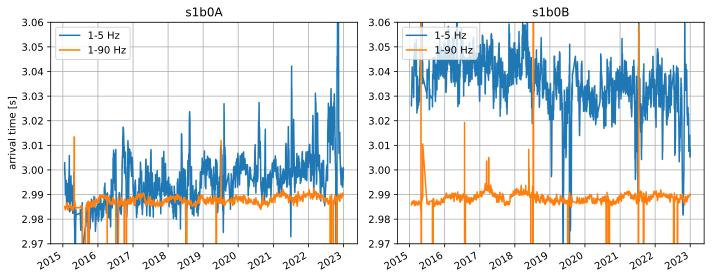

In [48]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
(-1*arrival_times_1_5['s1b0A']).plot(label='1-5 Hz')
(-1*arrival_times_1_90['s1b0A']).plot(label='1-90 Hz')

plt.ylim([2.97, 3.06])
plt.grid()
plt.ylabel('arrival time [s]')
plt.xlabel('')
plt.title('s1b0A')
plt.legend()

plt.subplot(1,2,2)
(arrival_times_1_5['s1b0B']).plot(label='1-5 Hz')
(arrival_times_1_90['s1b0B']).plot(label='1-90 Hz')

plt.ylim([2.97, 3.06])
plt.grid()
plt.ylabel('')
plt.xlabel('')
plt.title('s1b0B')
plt.legend(loc='upper left')

plt.tight_layout()
fig.savefig('figures/estimated_at_1-5_1-90.svg')

- for some reason the arrival time for the very low frequency EGF is ***WAY*** less accurate than the full band estimate

## Compare to HYCOM simulation

In [25]:
fn = '/datadrive/simulation/caldera_inversion_timeseries_HYCOM2.nc'
TDGFs = xr.open_dataarray(fn)

In [27]:
b,a = signal.butter(4, [0.01, 0.05], btype='bandpass')
TDGFs_1_5 = xrsignal.filtfilt(TDGFs, b=b, a=a, dim='time')

In [35]:
at_1_5_sim = inversion.calculate_arrival_times(TDGFs_1_5, dim='time', peaks={'s1b0':slice(2.5, 3.5)})
at_1_90_sim = inversion.calculate_arrival_times(TDGFs, dim='time', peaks={'s1b0':slice(2.5, 3.5)})

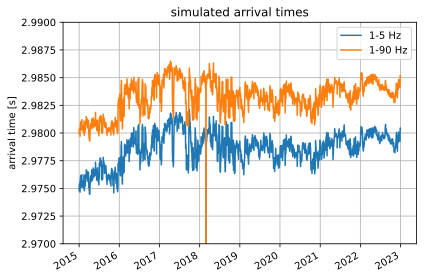

In [49]:
at_1_5_sim['s1b0'].plot(label='1-5 Hz')
at_1_90_sim['s1b0'].plot(label='1-90 Hz')
plt.grid()
plt.ylim([2.97, 2.99])
plt.legend()
plt.title('simulated arrival times')
plt.ylabel('arrival time [s]')
plt.xlabel('')

plt.tight_layout()

plt.savefig('figures/simulated_at_1-5_1-90.svg')

In [72]:
time_coord = pd.date_range(pd.Timestamp('2015-01-01'), pd.Timestamp('2023-01-01'), freq='1H')

In [78]:
at_1_90_sim_1hr = at_1_90_sim.interp({'date':time_coord}, method='cubic')

In [109]:
at_1_90_sim_201hr = at_1_90_sim_1hr.rolling(date=201).mean()['s1b0']

## Compare Lag and Lead

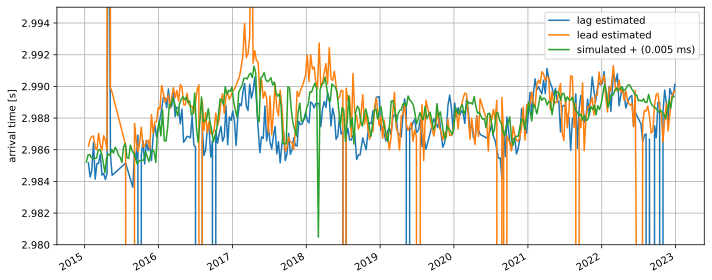

In [147]:
fig = plt.figure(figsize=(10,4))
(-1*arrival_times_1_90['s1b0A'][::201]).plot(label='lag estimated')
(arrival_times_1_90['s1b0B'][::201]).plot(label='lead estimated')
(at_1_90_sim_201hr[::201] + 0.005).plot(label='simulated + (0.005 ms)')
plt.ylim([2.98,2.995])
plt.grid()
plt.legend()
plt.ylabel('arrival time [s]')
plt.xlabel('')

plt.tight_layout()
fig.savefig('figures/estimated_and_simulated_arrival_times.svg')

In [118]:
arrival_times_1_90

<xarray.Dataset>
Dimensions:  (time: 64602)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-19T15:00:00 ... 2022-12-31T23:00:00
Data variables:
    dA       (time) float64 -2.212 -2.122 -2.121 -2.121 ... -2.073 -2.073 -2.073
    s1b0A    (time) float64 -2.985 -2.985 -2.985 -2.985 ... -2.99 -2.99 -2.99
    s1b0B    (time) float64 2.986 2.986 2.986 2.986 ... 2.99 2.99 2.99 2.99
    s2b1A    (time) float64 -4.655 -4.655 -4.655 -4.655 ... -4.654 -4.654 -4.654
    s2b1B    (time) float64 4.641 4.641 4.641 4.641 ... 4.671 4.671 4.671 4.671

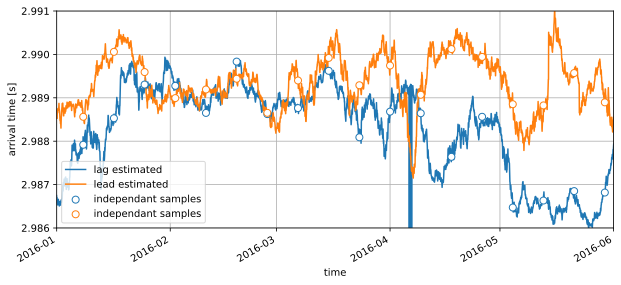

In [143]:
fig = plt.figure(figsize=(10,4))
(-1*arrival_times_1_90['s1b0A']).plot(label='lag estimated')
(arrival_times_1_90['s1b0B']).plot(label='lead estimated')


plt.scatter(arrival_times_1_90.time[::201], (-1*arrival_times_1_90['s1b0A'][::201]),s=50, c='white', edgecolors='C0', zorder=10, label='independant samples')
plt.scatter(arrival_times_1_90.time[::201], (arrival_times_1_90['s1b0B'][::201]),s=50, c='white', edgecolors='C1', zorder=10, label='independant samples')


plt.ylim([2.986,2.991])
plt.grid()
plt.legend(loc='lower left')
plt.xlim([pd.Timestamp('2016-01-01'), pd.Timestamp('2016-06-01')])
plt.ylabel('arrival time [s]')

fig.savefig('figures/1hr_vs_201hr.svg')

- why is this different from what I remember seeing?
- what was I doing differently?

In [148]:
fn = '/datadrive/NCCFs/arrival_times/outlier100_avghour201.nc'
at_old = xr.open_dataset(fn)

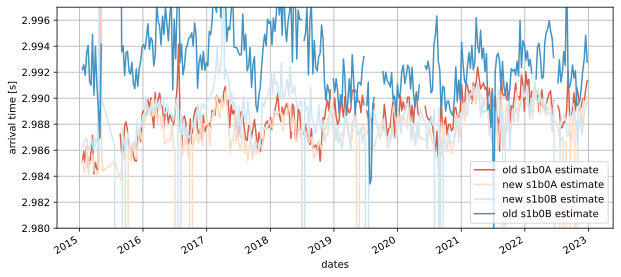

In [194]:
sns.set_palette('RdBu', n_colors=4)

fig = plt.figure(figsize=(10,4))

(-1*at_old['s1b0A'][::201]).plot(label='old s1b0A estimate')
(-1*arrival_times_1_90['s1b0A'][::201]).plot(label=('new s1b0A estimate'))


(arrival_times_1_90['s1b0B'][::201]).plot(label=('new s1b0B estimate'))
(at_old['s1b0B'][::201]).plot(label='old s1b0B estimate')

plt.legend()
plt.grid()
plt.ylabel('arrival time [s]')

plt.ylim([2.98,2.997])

fig.savefig('figures/new_vs_old_ats.svg')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 322/322 [00:02<00:00, 133.93it/s]


(-0.001, 0.003)

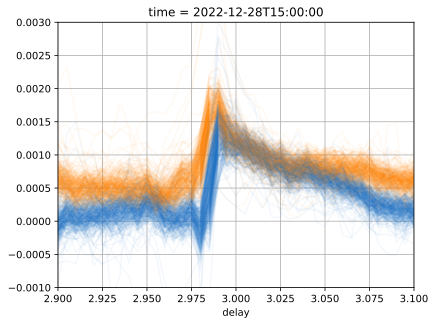

In [192]:
#sns.reset_defaults()

for k in tqdm(range(322)):
    NCCFs201[::201,:][k,:].sel({'delay':slice(2.5, 3.5)}).plot(c='C0', alpha=0.05)
    xrsignal.hilbert_mag(NCCFs201[::201,:][k,:].sel({'delay':slice(2.5, 3.5)}), dim='delay').plot(c='C1', alpha=0.05)
plt.grid()
plt.xlim([2.9, 3.1])
plt.ylim([-0.001, 0.003])

## Look at difference and mean of lag/lead

In [196]:
s1b0_mean = (-1*arrival_times_1_90['s1b0A'] + arrival_times_1_90['s1b0B'])/2
s1b0_diff = arrival_times_1_90['s1b0A'] + arrival_times_1_90['s1b0B']

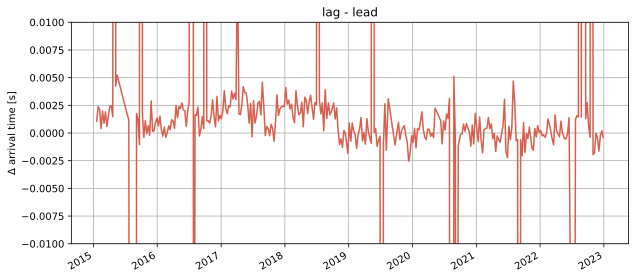

In [231]:
fig = plt.figure(figsize=(10,4))
s1b0_diff[::201].plot()
plt.ylim([-0.01, 0.01])
plt.grid()
plt.title('lag - lead')
plt.ylabel('$\\Delta$ arrival time [s]')
plt.xlabel('')
fig.savefig('figures/lag_lead_difference.svg')

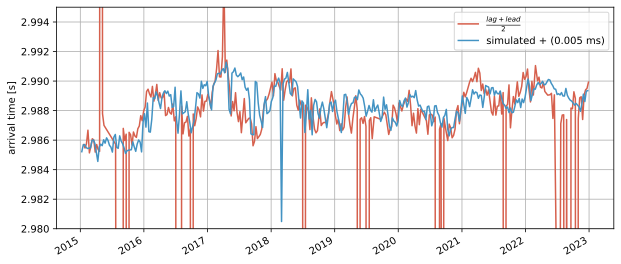

In [227]:
fig = plt.figure(figsize=(10,4))
s1b0_mean[::201].plot(label='$\\frac{lag + lead}{2}$')
#plt.ylim([-0.01, 0.01])
plt.grid()
(at_1_90_sim_201hr[::201] + 0.005).plot(label='simulated + (0.005 ms)', c='C3')

plt.legend()

plt.ylim([2.98,2.995])
plt.ylabel('arrival time [s]')
plt.xlabel('')

fig.savefig('figures/average_and_simulated_at.svg')